In [1]:
##### Copyright 2021 The Cirq Developers

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Circuit optimization, gate alignment, and spin echoes

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/google/spin_echoes"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/google/spin_echoes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/google/spin_echoes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/google/spin_echoes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to prepare circuits to run on the Quantum Computing Service (QCS) and optimize them to improve performace, showing an example of the procedure outlined in the [Best practices guide](https://quantumai.google/cirq/google/best_practices#improving_circuit_fidelity). This is an "advanced" tutorial where you will learn to perform the following optimization techniques:

1. Converting to target gateset
2. Ejecting single-qubit operations
3. Aligning gates in moments
4. Inserting spin echoes to reduce leakage & cross-talk.

Note: The function `cirq_google.optimized_for_sycamore` implements some of the optimizations shown here. This tutorial provides more detail for finer control.

## Setup
Note: this notebook relies on unreleased Cirq features. If you want to try these features, make sure you install cirq via `pip install cirq --pre`.

In [3]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq --pre
    print("installed cirq.")

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import cirq
import cirq_google as cg

In [5]:
import os

# The Google Cloud Project id to use.
project_id = '' #@param {type:"string"}
processor_id = "" #@param {type:"string"}

from cirq_google.engine.qcs_notebook import get_qcs_objects_for_notebook
device_sampler = get_qcs_objects_for_notebook(project_id, processor_id)

Getting OAuth2 credentials.
Press enter after entering the verification code.
Authentication complete.
Successful authentication to Google Cloud.


In [6]:
# @markdown Helper functions.
from typing import Optional, Sequence
from cirq.experiments import random_rotations_between_grid_interaction_layers_circuit


# Gates for spin echoes.
pi_pulses = [
    cirq.PhasedXPowGate(phase_exponent=p, exponent=1.0) for p in (-0.5, 0.0, 0.5, 1.0)
]


def create_benchmark_circuit(
    qubits: Sequence[cirq.GridQubit],
    cycles: int,
    twoq_gate: cirq.Gate = cirq.SQRT_ISWAP,
    seed: Optional[int] = None,
    with_optimization: bool = False,
    with_alignment: bool = False,
    with_spin_echoes: bool = False,
) -> cirq.Circuit:
    """Returns an "OTOC-like" circuit [1] used to benchmark optimization and/or
    alignment and/or spin echoes.

    Args:
        qubits: Qubits to use.
        cycles: Depth of random rotations in the forward & reverse unitary.
        twoq_gate: Two-qubit gate to use.
        seed: Seed for circuit generation.
        with_optimization: Run a series of optimizations on the circuit.
        with_alignment: Align moments and synchronize terminal measurements.
        with_spin_echoes: Insert spin echoes on ancilla qubit.
    
    References:
        [1] Fig. S10 of https://arxiv.org/abs/2101.08870.
    """
    ancilla, qubits = qubits[0], qubits[1:]

    # Put ancilla into the |1⟩ state and couple it to the rest of the qubits.
    excite_ancilla = [cirq.X(ancilla), twoq_gate(ancilla, qubits[0])]

    # Forward operations.
    forward = random_rotations_between_grid_interaction_layers_circuit(
        qubits, 
        depth=cycles,
        two_qubit_op_factory=lambda a, b, _: twoq_gate.on(a, b),
        pattern=cirq.experiments.GRID_STAGGERED_PATTERN,
        single_qubit_gates=[cirq.PhasedXPowGate(phase_exponent=p, exponent=0.5)
                            for p in np.arange(-1.0, 1.0, 0.25)],
        seed=seed
    )

    # Full circuit. Note: We are intentionally creating a bad circuit structure
    # by putting each operation in a new moment (via `cirq.InsertStrategy.New`)
    # to show the advantages of optimization & alignment.
    circuit = cirq.Circuit(excite_ancilla)
    circuit.append(forward.all_operations(), strategy=cirq.InsertStrategy.NEW)
    circuit.append(cirq.inverse(forward).all_operations(), strategy=cirq.InsertStrategy.NEW)
    circuit.append(cirq.inverse(excite_ancilla[1:]))
    circuit.append(cirq.measure(ancilla, key="z"), strategy=cirq.InsertStrategy.NEW)

    # Run optimization.
    if with_optimization:
        cirq.MergeInteractionsToSqrtIswap().optimize_circuit(circuit)
        circuit = cirq.eject_phased_paulis(circuit)
        circuit = cirq.eject_z(circuit)
        circuit = cirq.drop_negligible_operations(circuit)
        circuit = cirq.drop_empty_moments(circuit)

    # Insert spin echoes. Note: It's important to do this after optimization, as
    # optimization will remove spin echoes.
    if with_spin_echoes:
        random_state = np.random.RandomState(seed)

        spin_echo = []
        for _ in range(cycles * 2):
            op = random_state.choice(pi_pulses).on(ancilla)
            spin_echo += [op, cirq.inverse(op)]

        circuit.insert(2, spin_echo)

    # Alignment.
    if with_alignment:
        circuit = cirq.align_right(circuit)
        circuit = synchronize_terminal_measurements(circuit)

    return circuit


def to_survival_prob(result: cirq.Result) -> float:
    return np.mean(np.sum(result.measurements["z"], axis=1) == 1)

## Preparing circuits to run on QCS

For the sake of this tutorial, we will use a circuit structure created by the `create_benchmark_circuit` function defined above.

In [7]:
"""Create an example circuit."""
qubits = cirq.GridQubit.rect(2, 3)  # [cirq.GridQubit(x, y) for (x, y) in [(3, 2), (4, 2), (4, 1), (5, 1), (6, 1), (6, 2), (5, 2)]]
circuit = create_benchmark_circuit(qubits, twoq_gate=cirq.ISWAP, cycles=3, seed=1)

print("Example benchmark circuit:\n")
circuit

Example benchmark circuit:



(0, 0): ───X───iSwap────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap──────────────────────────────────────────────────────────M('z')───
               │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        │
(0, 1): ───────iSwap───PhX(0.25)^0.5──────────────────────────────────────────────────────────────────────PhX(-0.75)^0.5─────────────────────────────────────────────────────────────────iSwap───PhX(0.75)^0.5──────────────────────────────────────────────────────────────iSwap───────────PhX(0.25)^0.5──────────────────────────────────────────────────────────────PhX(0.25)^-0.5──────────────────────────────────────────────────────────────────iSwap─────────────────PhX(0.75)^-0.5──────────────────────────────────────────────────────────────────iSwap──────PhX(-0.75)^-0.5────────────────────────────────────────────────────────────────────────────────PhX(0.25)^-0.5───iSwap^-1────────────────────────────────────────────────────────────────
                                                                                                                                                                                         │                                                                                  │                                                                                                                                                                          │                                                                                                     │
(0, 2): ───────────────────────────────PhX(-0.25)^0.5─────────────────────────────────────────────iSwap────────────────────PhX(0.25)^0.5─────────────────────────────────────────────────┼───────────────────────PhX(0)^0.5─────────────────────────────────────────────────iSwap───────────────────────────PhX(-0.5)^0.5───────────────────────────────────────────────────────────────PhX(-0.5)^-0.5─────────────────────────────────────────────────iSwap^-1───────────────────────────────PhX(0)^-0.5────────────────────────────────────────────────────┼────────────────────────────PhX(0.25)^-0.5────────────────────────────────────────────────────iSwap───────────────────────PhX(-0.25)^-0.5─────────────────────────────────────────────────────────
                                                                                                  │                                                                                      │                                                                                                                                                                                                                                                                                                                                                                   │                                      

This circuit divides the qubits into two registers: a single ancilla (top qubit) as the first register, and the remaining qubits as the second register. First, the ancilla is excited into the $|1\rangle$ state and coupled to the second register. Then, a [Loschmidt echo](https://quantumai.google/cirq/tutorials/google/echoes) is performed on the second register. Last, the ancilla is uncoupled from the second register and measured. Without any noise, the only measurement result should be $1$.

In [8]:
"""Without noise, only the 1 state is measured."""
result = cirq.Simulator().run(circuit, repetitions=1000)
result.histogram(key="z")

Counter({1: 1000})

We choose this circuit as an example for two reasons:

1. Each gate in the circuit is in its own `cirq.Moment`, so this is a poor circuit structure to run on devices without any optimization / alignment.

2. The ancilla qubit is idle except at the start and end of the circuit, so this is a prime example where adding spin echoes can improve performance.

A similar circuit was used in [Information Scrambling in Computationally Complex Quantum Circuits](https://arxiv.org/abs/2101.08870) (see Fig. S10) to benchmark the performance of spin echoes.

Starting from this circuit, we show how to optimize gates, align moments, and insert spin echoes to improve the performance on a real device.

### Convert to target gateset

To run on a device, all gates in the circuit will be converted to a gateset supported by that device. (See the [Device specifications guide](https://quantumai.google/cirq/google/specification) for information on supported gatesets.)

We will use the $\sqrt{\text{iSWAP}}$ gateset in this tutorial. You can see this gateset and others as follows.

In [9]:
# Create an Engine object to use.
spec = cg.Engine(project_id).get_processor(processor_id).get_device_specification()

# Iterate through each gate set valid on the device.
for gateset in spec.valid_gate_sets:
    print(gateset.name)
    print('-------')
    # Prints each gate valid in the set with its duration
    for gate in gateset.valid_gates:
        print('%s %d' % (gate.id, gate.gate_duration_picos))
    print()

sycamore
-------
syc 12000
xy 25000
xy_pi 25000
xy_half_pi 25000
z 0
xyz 25000
meas 4000000
wait 0

sqrt_iswap
-------
fsim_pi_4 32000
inv_fsim_pi_4 32000
xy 25000
z 0
xyz 25000
meas 4000000
wait 0

fsim
-------
fsim 0
xy 25000
z 0
xyz 25000
meas 4000000
wait 0

xmon
-------
xy 25000
z 0
xyz 25000
cz 0
meas 4000000



To convert gates to this gateset, use the `cirq.MergeInteractionsToSqrtIswap` optimizer. This optimizer merges all consecutive (one- and two-qubit) interactions on two qubits into a unitary matrix and then decomposes this unitary using $\sqrt{\text{iSWAP}}$ gates in an attempt to (a) convert to the target gateset and (b) reduce the circuit depth by reducing the number of operations.

In [10]:
cirq.MergeInteractionsToSqrtIswap().optimize_circuit(circuit)
circuit

┌─────────────────────┐                                                                                                                                                              ┌───────────────────────┐   ┌───────────────────────┐                                                             ┌────────────────────┐
(0, 0): ───X───X───S───iSwap────────────iSwap────────Z──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────S────────────iSwap───────────────────iSwap─────────Z───────M('z')───
                       │                │                                                                                                                                                                                                                                                                                                                                                                                                                                                │                       │
(0, 1): ───────────────iSwap^0.5────────iSwap^0.5────X────────────S^-1────────────────────────────────────────────────────────────────────────────────────X───S^-1───iSwap────────────────────iSwap────────T───X^0.5───Z^0.75───T────────X^0.5────T^-1──────────────────────────────────────────────────────────────────────────────────────────────────X───Z^0.118──────────────────iSwap───────────────────────iSwap───────────────────────────────────────────────────────────────────iSwap^0.5───────────────iSwap^0.5─────S────────────────
                                                                                                                                                                     │                        │                                                                                                                                                                                      │                           │
(0, 2): ───────────────PhX(-0.25)^0.5─────────────────────────────────────────────Z^-0.145───iSwap───────iSwap───────T───────────────X^0.75───────────S──────────────┼────────────────────────┼─────────────────────────────────X^-0.5─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhX(0.25)^-0.5┼───────────────────────────┼─────────────────────────────────────X─────────Z^-0.016───iSwap───────────────────iSwap────────Z^-0.75───────X^0.5───Z^0.75───
                                                                                             │           │                                                           │                        │                                                                                                                                                                                      │                           │                                                          │                       │
(1, 0): ────────────────────────────────PhX(0)^0.5───────────────────────────────────────────┼───────────┼───────────PhX(0.75)^0.5───────────────────────────────────┼────────────PhX(0.5)^0.5┼──────────────────────────────────────────Y^-0.5──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────PhX(0.75)^-0.5┼──────────────────────────────────────────────────────────┼────────────PhX(0)^-0.5┼───────────────────────────────────────────
                                                                                             │           │                                                           │            

Note: Cirq supports decomposing to many different target gatesets via analytical decomposition functions present in `cirq.optimizers`. For example, you can compile an arbitrary two-qubit unitary (provided as a matrix) to $\sqrt{\text{iSWAP}}$ operations as shown below. This is useful when using custom gates in a circuit.

In [11]:
"""Compile an arbitrary two-qubit operation to the sqrt_iswap gateset."""
ops = cirq.two_qubit_matrix_to_sqrt_iswap_operations(
    q0=qubits[0], q1=qubits[1], mat=cirq.testing.random_unitary(dim=4, random_state=1)
)
cirq.Circuit(ops)

(0, 0): ───Z^0.07────X^0.501───Z^0.424───iSwap───────Z^(1/6)────X^0.022───Z^-0.217───iSwap───────Z^0.983────X^0.603───Z^-0.78───
                                         │                                           │
(0, 1): ───Z^0.543───X^0.26──────────────iSwap^0.5───Z^(5/13)───X^(1/3)──────────────iSwap^0.5───Z^-0.367───X^0.114───Z^0.18────

### Eject single-qubit operations

After converting to a target gateset, you can use various circuit optimizers to attempt to reduce the number of gates as shown below.

The `cirq.eject_phased_paulis` optimizer pushes `cirq.X`, `cirq.Y`, and `cirq.PhasedXPowGate` gates towards the end of the circuit.

In [12]:
circuit = cirq.eject_phased_paulis(circuit)
circuit

┌─────────────────────┐                                                                                                                                                                  ┌───────────────────────┐   ┌───────────────────────┐                                                                  ┌────────────────────┐
(0, 0): ───────────S───iSwap────────────iSwap────────Z───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────S────────────iSwap───────────────────iSwap─────────Z───────M('z')───
                       │                │                                                                                                                                                                                                                                                                                                                                                                                                                                                         │                       │
(0, 1): ───────────────iSwap^0.5────────iSwap^0.5─────────────────────────────────────────────────────────────────────────────────────────────────────────S───S^-1───iSwap────────────────────iSwap────────T───X^0.5───Z^0.75───T────────X^0.5────T^-1──────────────────────────────────────────────────────────────────────────────────────────────────────PhX(0.0592)──────────────────iSwap───────────────────────iSwap────────────────────────────────────────────────────────────────────────iSwap^0.5───────────────iSwap^0.5─────S────────────────
                                                                                                                                                                     │                        │                                                                                                                                                                                          │                           │
(0, 2): ───────────────PhX(-0.25)^0.5─────────────────────────────────────────────Z^-0.145───iSwap───────iSwap───────T───────────────X^0.75───────────S──────────────┼────────────────────────┼─────────────────────────────────X^-0.5─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhX(0.25)^-0.5┼───────────────────────────┼───────────────────────────────────────────────PhX(-0.00809)───iSwap───────────────────iSwap────────Z^-0.75───────X^0.5───Z^0.75───
                                                                                             │           │                                                           │                        │                                                                                                                                                                                          │                           │                                                               │                       │
(1, 0): ────────────────────────────────PhX(0)^0.5───────────────────────────────────────────┼───────────┼───────────PhX(0.75)^0.5───────────────────────────────────┼────────────PhX(0.5)^0.5┼──────────────────────────────────────────Y^-0.5──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────────PhX(0.75)^-0.5┼───────────────────────────────────────────────────────────────┼────────────PhX(0)^-0.5┼───────────────────────────────────────────
                                                                                             │           │     

Note that, for example, the back-to-back `cirq.X` gates on the ancilla have been removed from the start of the circuit.

You can also use the `cirq.eject_z` optimizer to attempt to push `cirq.Z` gates towards the end of the circuit.

In [13]:
circuit = cirq.eject_z(circuit)
circuit

┌─────────────────────┐                                                                                                                                                                                                 ┌───────────────────────┐   ┌───────────────────────┐                                                                ┌────────────────────┐
(0, 0): ───────────S───iSwap────────────iSwap───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────S^-1─────────iSwap───────────────────iSwap───────────────────────────────M('z')─────
                       │                │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    │                       │
(0, 1): ───────────────iSwap^0.5────────iSwap^0.5──────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap────────────────────iSwap────────────PhX(-0.25)^0.5─────────────────────────PhX(0.75)^0.5────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhX(-0.941)───Z──────────────────iSwap───────────────────────iSwap──────────────────────────────────────────────────────────────────────iSwap^0.5───────────────iSwap^0.5─────────S────────────────────────────
                                                                                                                                                                   │                        │                                                                                                                                                                                                                         │                           │
(0, 2): ───────────────PhX(-0.25)^0.5─────────────────────────────────────────────Z^-0.145───iSwap───────iSwap───────────────────────PhX(-0.25)^0.75───────────────┼────────────────────────┼─────────────────────────────────────PhX(-0.75)^-0.5───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhX(-0.5)^-0.5┼───────────────────────────┼──────────────────────────────────────PhX(-0.758)───Z^0.75───iSwap───────────────────iSwap──────────────────────────PhX(0.75)^0.5────────────────
                                                                                             │           │                                                         │                        │                                                                                                                                                                                                                         │                           │                                                             │                       │
(1, 0): ────────────────────────────────PhX(0)^0.5───────────────────────────────────────────┼───────────┼───────────PhX(0.75)^0.5─────────────────────────────────┼────────────PhX(0.5)^0.5┼───────────────────────────────────────────────────────Y^-0.5────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─

Note that, for example, the `cirq.Z` gate immediately before the ancilla measurement has been removed.

### Align gates in moments

After optimizing, gates should be aligned into `cirq.Moment`s to satisfy the following criteria:

- The fewer moments the better (generally speaking).
  - Each moment is a discrete time slice, so fewer moments means shorter circuit execution time.

- Moments should consist of gates with similar durations.
  - Otherwise some qubits will be idle for part of the moment.
  - It's best to align one-qubit gates in their own moment and two-qubit gates in their own moment if possible.

- All measurements should be terminal and in a single moment.
  - Intermediate measurements are not currently supported, and measurement operation times are roughly two orders of magnitude longer than other gate times (see the above cell which prints out gatesets and gate times).


To align gates into moments and push them as far left as possible, use `cirq.align_left`.

In [14]:
left_aligned_circuit = cirq.align_left(circuit)
left_aligned_circuit

┌─────────────────────┐   ┌────────────────────────┐   ┌────────────────────────┐                                                                                       ┌──────────────────┐   ┌───────────────────────┐
(0, 0): ───S────────────────iSwap─────────────iSwap─────────────────────S^-1─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap──────────────────────iSwap─────────────M('z')─────
                            │                 │                                                                                                                                                                                              │                          │
(0, 1): ────────────────────iSwap^0.5─────────iSwap^0.5──────────────────────────iSwap──────────────────────────────iSwap────────PhX(-0.25)^0.5────PhX(0.75)^0.5─────PhX(-0.941)───────Z─────────────────iSwap────────iSwap──────────────────iSwap^0.5──────────────────iSwap^0.5─────────S──────────
                                                                                 │                                  │                                                                                    │            │
(0, 2): ───PhX(-0.25)^0.5───Z^-0.145──────────iSwap─────────────────────iSwap────┼───────────────────PhX(-0.25)^0.75┼────────────PhX(-0.75)^-0.5───PhX(-0.5)^-0.5────PhX(-0.758)───────Z^0.75────────────┼────────────┼────────iSwap───────────────────────iSwap────────PhX(0.75)^0.5────────────────
                                              │                         │        │                                  │                                                                                    │            │        │                           │
(1, 0): ───PhX(0)^0.5───────PhX(0.75)^0.5─────┼────────PhX(0.5)^0.5─────┼────────┼────────Y^-0.5─────PhX(0.75)^-0.5─┼────────────PhX(0)^-0.5─────────────────────────────────────────────────────────────┼────────────┼────────┼───────────────────────────┼─────────────────────────────────────────
                                              │                         │        │                                  │                                                                                    │            │        │                           │
(1, 1): ───PhX(1)^0.5───────PhX(-0.75)^0.5────┼─────────────────────────┼────────iSwap^0.5──────────────────────────iSwap^0.5────PhX(0)^0.5────────PhX(0)^0.5────────S───────────────────────────────────iSwap^0.5────iSwap^0.5┼─────────────PhX(0.868)^0.5┼────────────PhX(0.618)^-0.5───Z^0.382────
                                              │                         │                                                                                                                                                      │                           │
(1, 2): ───PhX(0.75)^0.5──────────────────────iSwap^0.5─────────────────iSwap^0.5────────────────────PhX(0.355)^0.5──────────────PhX(0.355)^0.5────PhX(0.355)^-0.5───PhX(0.855)^-0.5───PhX(0.355)^-0.5───Z^-0.355──────────────iSwap^0.5───────────────────iSwap^0.5────PhX(-0.766)^0.5───Z^-0.484───
                                             └─────────────────────┘   └────────────────────────┘   └────────────────────────┘                                                                                       └──────────────────┘   └───────────────────────┘

Note: Optimizers can cause terminal measurements to become misaligned, but this can be fixed with `cirq.synchronize_terminal_measurements` as discussed below.

Note how many fewer moments this aligned circuit has.

In [15]:
print(f"Original circuit has {len(circuit)} moments.")
print(f"Aligned circuit has {len(left_aligned_circuit)} moments.")

Original circuit has 54 moments.
Aligned circuit has 14 moments.


You can also align gates and push them to the right with `cirq.align_right`.

In [16]:
right_aligned_circuit = cirq.align_right(circuit)
right_aligned_circuit

┌───────────────────────┐   ┌──────────────────┐                                                                                            ┌──────────────────────┐   ┌──────────────────────────────┐   ┌───────────────────────┐
(0, 0): ───S────────────────iSwap────────────iSwap──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────S^-1───────────────────────────────iSwap──────────────────────iSwap─────────────M('z')──────────
                            │                │                                                                                                                                                                                                         │                          │
(0, 1): ────────────────────iSwap^0.5────────iSwap^0.5───────────────────iSwap─────────────────iSwap────────────PhX(-0.25)^0.5────PhX(0.75)^0.5─────PhX(-0.941)───────Z───────────────────────────────iSwap──────────────────iSwap─────────────────────iSwap^0.5──────────────────iSwap^0.5─────────S───────────────
                                                                         │                     │                                                                                                      │                      │
(0, 2): ───PhX(-0.25)^0.5───Z^-0.145───────────────────────iSwap─────────┼────────iSwap────────┼────────────────PhX(-0.25)^0.75───PhX(-0.75)^-0.5───PhX(-0.5)^-0.5────PhX(-0.758)────────Z^0.75───────┼─────────────iSwap────┼─────────────────────────iSwap────────────────────────────────────────PhX(0.75)^0.5───
                                                           │             │        │            │                                                                                                      │             │        │                         │
(1, 0): ───────────────────────────────────────────────────┼─────────────┼────────┼────────────┼──────────────────────────────────────────────────────────────────────PhX(0)^0.5─────────PhX(0.75)^0.5┼─────────────┼────────┼────────PhX(0.5)^0.5─────┼────────Y^-0.5────────────PhX(0.75)^-0.5────PhX(0)^-0.5─────
                                                           │             │        │            │                                                                                                      │             │        │                         │
(1, 1): ────────────────────PhX(1)^0.5───────PhX(-0.75)^0.5┼─────────────iSwap^0.5┼────────────iSwap^0.5──────────────────────────PhX(0)^0.5────────PhX(0)^0.5────────S───────────────────────────────iSwap^0.5─────┼────────iSwap^0.5─────────────────┼────────PhX(0.868)^0.5────PhX(0.618)^-0.5───Z^0.382─────────
                                                           │                      │                                                                                                                                 │                                  │
(1, 2): ────────────────────PhX(0.75)^0.5──────────────────iSwap^0.5──────────────iSwap^0.5────PhX(0.355)^0.5───PhX(0.355)^0.5────PhX(0.355)^-0.5───PhX(0.855)^-0.5───PhX(0.355)^-0.5────Z^-0.355───────────────────iSwap^0.5──────────────────────────iSwap^0.5──────────────────PhX(-0.766)^0.5───Z^-0.484────────
                                            └───────────────────────┘   └──────────────────┘                                                                                            └──────────────────────┘   └──────────────────────────────┘   └───────────────────────┘

Also, you can use `cirq.stratified_circuit` to align operations into similar categories. For example, you can align single-qubit and two-qubit operations in separate moments as follows.

In [17]:
circuit = cirq.stratified_circuit(
    circuit, categories=[lambda op : len(op.qubits) == 1, lambda op : len(op.qubits) == 2]
)
circuit

┌──────────────────┐                                                                                                                                ┌──────────────────┐
(0, 0): ───S────────────────iSwap────────────────────────iSwap───────S^-1───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap─────────────────────────iSwap───────M('z')─────
                            │                            │                                                                                                                                                                                                                      │                             │
(0, 1): ────────────────────iSwap^0.5────────────────────iSwap^0.5────────────────────────────iSwap──────────────────────────iSwap───────PhX(-0.25)^0.5────PhX(0.75)^0.5─────PhX(-0.941)───────Z─────────────────iSwap───────────────────iSwap──────────────────────────────────iSwap^0.5─────────────────────iSwap^0.5───S──────────
                                                                                              │                              │                                                                                   │                       │
(0, 2): ───PhX(-0.25)^0.5───────────────Z^-0.145─────────iSwap───────────────────────iSwap────┼────────────PhX(-0.25)^0.75───┼───────────PhX(-0.75)^-0.5───PhX(-0.5)^-0.5────PhX(-0.758)───────Z^0.75────────────┼───────────────────────┼────────iSwap─────────────────────────iSwap───────PhX(0.75)^0.5────────────────────────────
                                                         │                           │        │                              │                                                                                   │                       │        │                             │
(1, 0): ───PhX(0)^0.5───────────────────PhX(0.75)^0.5────┼───────────PhX(0.5)^0.5────┼────────┼────────────Y^-0.5────────────┼───────────PhX(0.75)^-0.5────PhX(0)^-0.5───────────────────────────────────────────┼───────────────────────┼────────┼─────────────────────────────┼────────────────────────────────────────────────────
                                                         │                           │        │                              │                                                                                   │                       │        │                             │
(1, 1): ───PhX(1)^0.5───────────────────PhX(-0.75)^0.5───┼───────────────────────────┼────────iSwap^0.5──────────────────────iSwap^0.5───PhX(0)^0.5────────PhX(0)^0.5────────S───────────────────────────────────iSwap^0.5───────────────iSwap^0.5┼────────────PhX(0.868)^0.5───┼───────────PhX(0.618)^-0.5───────────────Z^0.382────
                                                         │                           │                                                                                                                                                            │                             │
(1, 2): ───PhX(0.75)^0.5─────────────────────────────────iSwap^0.5───────────────────iSwap^0.5─────────────PhX(0.355)^0.5────────────────PhX(0.355)^0.5────PhX(0.355)^-0.5───PhX(0.855)^-0.5───PhX(0.355)^-0.5───────────────Z^-0.355─────────────iSwap^0.5─────────────────────iSwap^0.5───PhX(-0.766)^0.5───────────────Z^-0.484───
                                                                                    └──────────────────┘                                                                                                                                └──────────────────┘

Note that each moment now only contains single-qubit gates or two-qubit gates.

#### Drop moments

To drop moments that have a tiny effect or moments that are empty, you can use the following optimizers.

In [18]:
circuit = cirq.drop_negligible_operations(circuit)
circuit = cirq.drop_empty_moments(circuit)
circuit

┌──────────────────┐                                                                                                                                ┌──────────────────┐
(0, 0): ───S────────────────iSwap────────────────────────iSwap───────S^-1───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap─────────────────────────iSwap───────M('z')─────
                            │                            │                                                                                                                                                                                                                      │                             │
(0, 1): ────────────────────iSwap^0.5────────────────────iSwap^0.5────────────────────────────iSwap──────────────────────────iSwap───────PhX(-0.25)^0.5────PhX(0.75)^0.5─────PhX(-0.941)───────Z─────────────────iSwap───────────────────iSwap──────────────────────────────────iSwap^0.5─────────────────────iSwap^0.5───S──────────
                                                                                              │                              │                                                                                   │                       │
(0, 2): ───PhX(-0.25)^0.5───────────────Z^-0.145─────────iSwap───────────────────────iSwap────┼────────────PhX(-0.25)^0.75───┼───────────PhX(-0.75)^-0.5───PhX(-0.5)^-0.5────PhX(-0.758)───────Z^0.75────────────┼───────────────────────┼────────iSwap─────────────────────────iSwap───────PhX(0.75)^0.5────────────────────────────
                                                         │                           │        │                              │                                                                                   │                       │        │                             │
(1, 0): ───PhX(0)^0.5───────────────────PhX(0.75)^0.5────┼───────────PhX(0.5)^0.5────┼────────┼────────────Y^-0.5────────────┼───────────PhX(0.75)^-0.5────PhX(0)^-0.5───────────────────────────────────────────┼───────────────────────┼────────┼─────────────────────────────┼────────────────────────────────────────────────────
                                                         │                           │        │                              │                                                                                   │                       │        │                             │
(1, 1): ───PhX(1)^0.5───────────────────PhX(-0.75)^0.5───┼───────────────────────────┼────────iSwap^0.5──────────────────────iSwap^0.5───PhX(0)^0.5────────PhX(0)^0.5────────S───────────────────────────────────iSwap^0.5───────────────iSwap^0.5┼────────────PhX(0.868)^0.5───┼───────────PhX(0.618)^-0.5───────────────Z^0.382────
                                                         │                           │                                                                                                                                                            │                             │
(1, 2): ───PhX(0.75)^0.5─────────────────────────────────iSwap^0.5───────────────────iSwap^0.5─────────────PhX(0.355)^0.5────────────────PhX(0.355)^0.5────PhX(0.355)^-0.5───PhX(0.855)^-0.5───PhX(0.355)^-0.5───────────────Z^-0.355─────────────iSwap^0.5─────────────────────iSwap^0.5───PhX(-0.766)^0.5───────────────Z^-0.484───
                                                                                    └──────────────────┘                                                                                                                                └──────────────────┘

#### Synchronize terminal measurements

You can use the `cirq.synchronize_terminal_measurements` to move all measurements to the final moment if it can accommodate them (without overlapping with other operations).

In [19]:
circuit = cirq.synchronize_terminal_measurements(circuit)
circuit

┌──────────────────┐                                                                                                                                ┌──────────────────┐
(0, 0): ───S────────────────iSwap────────────────────────iSwap───────S^-1───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap─────────────────────────iSwap──────────────────M('z')───
                            │                            │                                                                                                                                                                                                                      │                             │
(0, 1): ────────────────────iSwap^0.5────────────────────iSwap^0.5────────────────────────────iSwap──────────────────────────iSwap───────PhX(-0.25)^0.5────PhX(0.75)^0.5─────PhX(-0.941)───────Z─────────────────iSwap───────────────────iSwap──────────────────────────────────iSwap^0.5─────────────────────iSwap^0.5───S───────────────────
                                                                                              │                              │                                                                                   │                       │
(0, 2): ───PhX(-0.25)^0.5───────────────Z^-0.145─────────iSwap───────────────────────iSwap────┼────────────PhX(-0.25)^0.75───┼───────────PhX(-0.75)^-0.5───PhX(-0.5)^-0.5────PhX(-0.758)───────Z^0.75────────────┼───────────────────────┼────────iSwap─────────────────────────iSwap───────PhX(0.75)^0.5─────────────────────────────────────
                                                         │                           │        │                              │                                                                                   │                       │        │                             │
(1, 0): ───PhX(0)^0.5───────────────────PhX(0.75)^0.5────┼───────────PhX(0.5)^0.5────┼────────┼────────────Y^-0.5────────────┼───────────PhX(0.75)^-0.5────PhX(0)^-0.5───────────────────────────────────────────┼───────────────────────┼────────┼─────────────────────────────┼─────────────────────────────────────────────────────────────
                                                         │                           │        │                              │                                                                                   │                       │        │                             │
(1, 1): ───PhX(1)^0.5───────────────────PhX(-0.75)^0.5───┼───────────────────────────┼────────iSwap^0.5──────────────────────iSwap^0.5───PhX(0)^0.5────────PhX(0)^0.5────────S───────────────────────────────────iSwap^0.5───────────────iSwap^0.5┼────────────PhX(0.868)^0.5───┼───────────PhX(0.618)^-0.5───────────────Z^0.382─────────────
                                                         │                           │                                                                                                                                                            │                             │
(1, 2): ───PhX(0.75)^0.5─────────────────────────────────iSwap^0.5───────────────────iSwap^0.5─────────────PhX(0.355)^0.5────────────────PhX(0.355)^0.5────PhX(0.355)^-0.5───PhX(0.855)^-0.5───PhX(0.355)^-0.5───────────────Z^-0.355─────────────iSwap^0.5─────────────────────iSwap^0.5───PhX(-0.766)^0.5───────────────Z^-0.484────────────
                                                                                    └──────────────────┘                                                                                                                                └──────────────────┘

## Adding spin echoes

[Dynamical decoupling](https://arxiv.org/abs/quant-ph/9803057) applies a series of spin echoes to otherwise idle qubits to reduce decoherent effects. As mentioned above, spin echoes were used as an effective error mitigation technique in [Information Scrambling in Computationally Complex Quantum Circuits](https://arxiv.org/abs/2101.08870), and the performance of any circuit with idle qubits can potentially be improved by adding spin echoes.

The following codeblock shows how to insert spin echoes on the ancilla qubit.

In [20]:
# Gates for spin echoes. Note that these gates are self-inverse.
pi_pulses = [
    cirq.PhasedXPowGate(phase_exponent=p, exponent=1.0) for p in (-0.5, 0.0, 0.5, 1.0)
]

# Generate spin echoes on ancilla.
num_echoes = 3
random_state = np.random.RandomState(1)

spin_echo = []
for _ in range(num_echoes):
    op = random_state.choice(pi_pulses).on(qubits[0])
    spin_echo += [op, cirq.inverse(op)]

# Insert spin echo operations to circuit.
optimized_circuit_with_spin_echoes = circuit.copy()
optimized_circuit_with_spin_echoes.insert(5, spin_echo)

# Align single-qubit spin echo gates into other moments of single-qubit gates.
optimized_circuit_with_spin_echoes = cirq.stratified_circuit(
    optimized_circuit_with_spin_echoes, 
    categories=[lambda op : len(op.qubits) == 1, lambda op : len(op.qubits) == 2]
)
optimized_circuit_with_spin_echoes

┌──────────────────┐                                                                                                                                 ┌──────────────────┐
(0, 0): ───S────────────────iSwap────────────────────────iSwap───────S^-1──────────────────────────────────PhX(0)────────────────────────PhX(0)────────────PhX(1)────────────PhX(1)────────────PhX(-0.5)─────────────────────PhX(-0.5)───────────────────────────────────────────iSwap─────────────────────────iSwap───────M('z')─────
                            │                            │                                                                                                                                                                                                                       │                             │
(0, 1): ────────────────────iSwap^0.5────────────────────iSwap^0.5────────────────────────────iSwap──────────────────────────iSwap───────PhX(-0.25)^0.5────PhX(0.75)^0.5─────PhX(-0.941)───────Z─────────────────iSwap────────────────────iSwap──────────────────────────────────iSwap^0.5─────────────────────iSwap^0.5───S──────────
                                                                                              │                              │                                                                                   │                        │
(0, 2): ───PhX(-0.25)^0.5───────────────Z^-0.145─────────iSwap───────────────────────iSwap────┼────────────PhX(-0.25)^0.75───┼───────────PhX(-0.75)^-0.5───PhX(-0.5)^-0.5────PhX(-0.758)───────Z^0.75────────────┼────────────────────────┼────────iSwap─────────────────────────iSwap───────PhX(0.75)^0.5────────────────────────────
                                                         │                           │        │                              │                                                                                   │                        │        │                             │
(1, 0): ───PhX(0)^0.5───────────────────PhX(0.75)^0.5────┼───────────PhX(0.5)^0.5────┼────────┼────────────Y^-0.5────────────┼───────────PhX(0.75)^-0.5────PhX(0)^-0.5───────────────────────────────────────────┼────────────────────────┼────────┼─────────────────────────────┼────────────────────────────────────────────────────
                                                         │                           │        │                              │                                                                                   │                        │        │                             │
(1, 1): ───PhX(1)^0.5───────────────────PhX(-0.75)^0.5───┼───────────────────────────┼────────iSwap^0.5──────────────────────iSwap^0.5───PhX(0)^0.5────────PhX(0)^0.5────────S───────────────────────────────────iSwap^0.5────────────────iSwap^0.5┼────────────PhX(0.868)^0.5───┼───────────PhX(0.618)^-0.5───────────────Z^0.382────
                                                         │                           │                                                                                                                                                             │                             │
(1, 2): ───PhX(0.75)^0.5─────────────────────────────────iSwap^0.5───────────────────iSwap^0.5─────────────PhX(0.355)^0.5────────────────PhX(0.355)^0.5────PhX(0.355)^-0.5───PhX(0.855)^-0.5───PhX(0.355)^-0.5───────────────Z^-0.355──────────────iSwap^0.5─────────────────────iSwap^0.5───PhX(-0.766)^0.5───────────────Z^-0.484───
                                                                                    └──────────────────┘                                                                                                                                 └──────────────────┘

The ancilla now has spin echoes between the two-qubit gates at the start/end of the circuit instead of remaining idle.

## Benchmark

Now that we have discussed how to remove uncessary gates, align gates, and insert spin echoes, we run an experiment to benchmark the results. First we get a line of qubits, list of cycle values (one circuit per cycle value), and set other experimental parameters.

In [21]:
"""Set experiment parameters."""
qubits = cg.line_on_device(device_sampler.device, length=7)
cycle_values = range(0, 100 + 1, 4)
nreps = 20_000
seed = 1

The `create_benchmark_circuit` defined at the start of this tutorial has options to optimize the circuit and insert spin echoes on the ancilla as we have discussed above. Without any optimization or spin echoes, an example circuit looks like this:

In [22]:
circuit = create_benchmark_circuit(qubits, cycles=2, seed=1)
print(f"Unoptimized circuit ({len(circuit)} moments):\n")
circuit

Unoptimized circuit (47 moments):



┌─────────────────────────┐
(3, 2): ───X───iSwap────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────iSwap────────────────────────────────────────────────────────────────────────M('z')───
               │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            │
(4, 1): ───────┼───────────────────────────PhX(-0.25)^0.5───────────────────────────────────────────────────────────────────────────────────────────────────────PhX(0.25)^0.5─────────────────────────────────────────────────────────────────iSwap───────────────────────────────────PhX(0)^0.5──────────────────────────────────────────────────────────────────────────────────PhX(0)^-0.5─────────────────────────────────────────────────────────────────────iSwap───────────────────────────────────────PhX(0.25)^-0.5─────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhX(-0.25)^-0.5┼─────────────────────────────────────────────────────────────────────────────────────
               │                                                                                                                                                                                                                              │                                                                                                                                                                                                                   │                                                                                                                                                                                         │
(4, 2): ───────iSwap^0.5───PhX(0.25)^0.5───────────────────────────────────────────────────────────────────────────────iSwap───────────────────PhX(-0.25)^0.5─────────────────────────────────────────────────────────────────────────────────┼───────────────────────PhX(0.25)^0.5──────────────────────────────────────────────────────────────────────────────PhX(0.25)^-0.5───────────────────────────────────────────────────────────────────────────────────┼─────────────────────────PhX(-0.25)^-0.5──────────────────────────────────────────────────────────────────────────────────────iSwap─────────────────────PhX(0.25)^-0.5───────────────────iSwap^-0.5────────────────────────────────────────────────────────────────────────────
                                                                                                                       │                                                                                                                      │                                                                                                                                                                                                                   │                                                                            

After removing unnecessary gates (optimization) and aligning gates, the same circuit looks like this:

In [23]:
optimized_circuit = create_benchmark_circuit(qubits, cycles=2, seed=1, with_optimization=True, with_alignment=True)
print(f"Circuit with optimization + alignment ({len(optimized_circuit)} moments):\n")
optimized_circuit

Circuit with optimization + alignment (15 moments):



┌────────────────────────────┐                                     ┌─────────────────────────┐
(3, 2): ───PhX(0)───iSwap────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Z────────────────iSwap──────────────────────────────────────────M('z')───
                    │                                                                                                                                                                                                 │
(4, 1): ────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhX(-0.25)^0.5────PhX(0.25)^0.5────┼──────────PhX(-0.75)^0.5────PhX(-0.25)^-0.5────────────
                    │                                                                                                                                                                                                 │
(4, 2): ────────────iSwap^0.5───PhX(0.25)^0.5────iSwap───────PhX(-0.25)^0.5───PhX(0.25)^0.5───PhX(0.25)^-0.5───PhX(-0.25)^-0.5───Z─────────────────iSwap───────────────────────────PhX(0.25)^0.5─────Z────────────────iSwap^0.5───────────────────────────────────────────────
                                                 │                                                                                                 │
(5, 1): ─────────────────────────────────────────┼────────────────────────────PhX(0)^0.5──────iSwap──────────────────────────────PhX(0.75)^0.5─────┼─────────────PhX(-0.25)^0.5────Z─────────────────iSwap────────────PhX(1)^-0.5──────────────────Z──────────────────────────
                                                 │                                            │                                                    │                                                 │
(5, 2): ────────────────────────PhX(-0.75)^0.5───iSwap^0.5────────────────────────────────────┼────────────────PhX(0.75)^0.5─────PhX(-0.25)^0.5────iSwap^0.5─────────────────────────────────────────┼─────────────────────────────────────────────PhX(-0.75)^-0.5────────────
                                                                                              │                                                                                                      │
(6, 1): ──────────────────────────────────────────────────────────────────────PhX(1)^0.5──────iSwap^0.5────────PhX(-0.75)^0.5────PhX(-0.5)^0.5─────PhX(-0.5)^-0.5──────────────────PhX(-0.75)^-0.5───iSwap^0.5─────────────────────────────────────X^0.5──────────────────────

(6, 2): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhX(0.75)^0.5─────PhX(0)^0.5───────X^-0.5───────────────────────PhX(0.75)^-0.5─────────────
                                                                                                                                                  └────────────────────────────┘                                     └─────────────────────────┘

And with optimization + alginment + spin echoes on the ancilla, the same circuit looks like this:

In [24]:
optimized_circuit_with_spin_echoes = create_benchmark_circuit(qubits, cycles=2, seed=1, with_optimization=True, with_alignment=True, with_spin_echoes=True)
print(f"Circuit with optimization + alignment + spin echoes ({len(optimized_circuit_with_spin_echoes)} moments):\n")
optimized_circuit_with_spin_echoes

Circuit with optimization + alignment + spin echoes (15 moments):



┌────────────────────────────┐                                     ┌─────────────────────────┐
(3, 2): ───PhX(0)───iSwap────────────────────────PhX(0)──────PhX(0)───────────PhX(1)──────────PhX(1)───────────PhX(-0.5)─────────PhX(-0.5)─────────PhX(-0.5)───────────────────────PhX(-0.5)─────────Z────────────────iSwap──────────────────────────────────────────M('z')───
                    │                                                                                                                                                                                                 │
(4, 1): ────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhX(-0.25)^0.5────PhX(0.25)^0.5────┼──────────PhX(-0.75)^0.5────PhX(-0.25)^-0.5────────────
                    │                                                                                                                                                                                                 │
(4, 2): ────────────iSwap^0.5───PhX(0.25)^0.5────iSwap───────PhX(-0.25)^0.5───PhX(0.25)^0.5───PhX(0.25)^-0.5───PhX(-0.25)^-0.5───Z─────────────────iSwap───────────────────────────PhX(0.25)^0.5─────Z────────────────iSwap^0.5───────────────────────────────────────────────
                                                 │                                                                                                 │
(5, 1): ─────────────────────────────────────────┼────────────────────────────PhX(0)^0.5──────iSwap──────────────────────────────PhX(0.75)^0.5─────┼─────────────PhX(-0.25)^0.5────Z─────────────────iSwap────────────PhX(1)^-0.5──────────────────Z──────────────────────────
                                                 │                                            │                                                    │                                                 │
(5, 2): ────────────────────────PhX(-0.75)^0.5───iSwap^0.5────────────────────────────────────┼────────────────PhX(0.75)^0.5─────PhX(-0.25)^0.5────iSwap^0.5─────────────────────────────────────────┼─────────────────────────────────────────────PhX(-0.75)^-0.5────────────
                                                                                              │                                                                                                      │
(6, 1): ──────────────────────────────────────────────────────────────────────PhX(1)^0.5──────iSwap^0.5────────PhX(-0.75)^0.5────PhX(-0.5)^0.5─────PhX(-0.5)^-0.5──────────────────PhX(-0.75)^-0.5───iSwap^0.5─────────────────────────────────────X^0.5──────────────────────

(6, 2): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────PhX(0.75)^0.5─────PhX(0)^0.5───────X^-0.5───────────────────────PhX(0.75)^-0.5─────────────
                                                                                                                                                  └────────────────────────────┘                                     └─────────────────────────┘

Now we create circuits for all cycle values without optimization, with optimization + alignment, and with optimization + alignment + spin echoes.

In [25]:
"""Create all circuits."""
batch = [
    create_benchmark_circuit(qubits, cycles=c, seed=seed)
    for c in cycle_values
]
batch_with_optimization = [
    create_benchmark_circuit(qubits, cycles=c, seed=seed, with_optimization=True, with_alignment=True)
    for c in cycle_values
]
batch_with_optimization_and_spin_echoes = [
    create_benchmark_circuit(qubits, cycles=c, seed=seed, with_optimization=True, with_alignment=True, with_spin_echoes=True)
    for c in cycle_values
]

The next cell runs them on the device.

In [26]:
"""Run all circuits."""
all_probs = []
for b in (batch, batch_with_optimization, batch_with_optimization_and_spin_echoes):
    results = device_sampler.sampler.run_batch(b, repetitions=nreps)
    all_probs.append([to_survival_prob(*res) for res in results])

And the next cell plots the results.

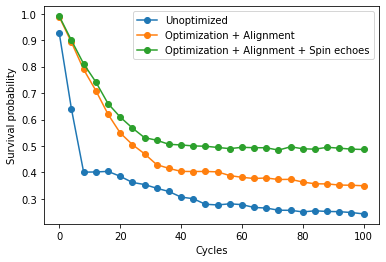

In [27]:
"""Plot results."""
labels = ["Unoptimized", "Optimization + Alignment", "Optimization + Alignment + Spin echoes"]

for (probs, label) in zip(all_probs, labels):
    plt.plot(cycle_values, probs, "-o", label=label)

plt.xlabel("Cycles")
plt.ylabel("Survival probability")
plt.legend();

Recall that without any noise, the survival probability (ratio of $1$s measured to all measurements) should be $1.0$, so higher on this plot is better. The unoptimized circuit performs the worst, the circuit with optimization + alignment performs better, and the circuit with optimization + alignment + spin echoes performs the best.